# 4.2.  Counterfactual Explanations
### Alex Gagliano (gaglian2@mit.edu)
### August 2nd, 2023
References and resources for additional reading:
* [Alibi Explain: Algorithms for Explaining Machine Learning Models](https://github.com/SeldonIO/alibi) (Klaise, Van Looveren, Vacanti, & Alexandru Coc, 2017)
* [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/), Christoph Molnar
* [Machine Learning Tutorials](https://github.com/MichelleLochner/ml-tutorials/tree/main), Michelle Lochner
* [Interpretable Counterfactual Explanations Guided by Prototypes](https://arxiv.org/abs/1907.02584), (Van Looveren & Klaise, 2019)

Often times, we describe an "interpretable model" as one in which it is clear how input maps to output. We looked at SHAP values to better understand what features might have 'pushed' a result in a particular direction, but another way to explore this mapping is to change the inputs and evaluate its impact on the outputs. 

In this notebook, we'll explore multi-class classification. We have examples in our training class belonging to a given class. Take an image of a spiral galaxy, for example. What do I have to modify in that image, and by how much, before my model believes that it's no longer a spiral galaxy? An example that answers this question is called a "counterfactual", which describes the smallest change to a set of feature values that will flip the predicted output. Exploring counterfactuals helps us understand what the 'boundaries' of our decision-making model are, which in turn helps us understand what features are important for decision-making. 

For a given set of input features $x$, a counterfactual $x'$ can be found by minimizing a loss function of the following general form:
$$ L(x'|x) = (f_t(x') - p_t)^2 + \lambda d(x, x')$$

Where $f_t(x')$ describes the class probability of counterfactual with features $x'$ (how confident we want the new prediction to be), $p_t$ defines the target class probability (defined in advance), $\lambda$ is a regularization parameter that is determined during fitting, and $d(x, x')$ is some distance measure between feature sets $x$ and $x'$ (Manhattan distance, L1 or L2-norm, etc). 

Counterfactuals are another example of a _local_ explanation model - we investigate the complex model's behavior at and near a specific set of input features.

## 4.2.1. Image counterfactuals

In [1]:
!pip install alibi torch torchvision

In [7]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import os

In [8]:
batch_size = 8

In [9]:
galaxyPath = './data/galaxy/'
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()])

train = torchvision.datasets.ImageFolder(os.path.join(galaxyPath, 'train'), transform = data_transform)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)

test = torchvision.datasets.ImageFolder(os.path.join(galaxyPath, 'test'), transform = data_transform)
test_loader = DataLoader(test, shuffle=True, batch_size=batch_size)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [11]:
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(3, 20, kernel_size=5),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(720, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 3*16*15)
        x = self.fc_layers(x)
        return x

In [14]:
model = Net().to(device)

#load the model from the SHAP tutorial!
model.load_state_dict(torch.load('./galaxyCNN_legacy.pth'))

<All keys matched successfully>

In [15]:
model.eval()

# Note! A pytorch model's forward function returns return a tensor and not a numpy array. 
# We have to do slightly more work to get the counterfactual package to play nicely with
# the model we've trained.

@torch.no_grad()
def predictor(X: np.ndarray) -> np.ndarray:
    X = torch.as_tensor(X,dtype=torch.float, device=device)
    return model.forward(X).cpu().numpy()

In [16]:
#gather the next batch from the dataset

image, label = next(iter(test_loader)) 
X = image[6:7]

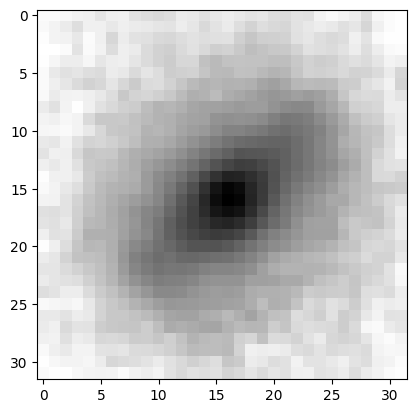

In [19]:
#here our instance of choice is the following image:
plt.imshow(X.squeeze(0,1), cmap='gray');

In [20]:
_, prediction = torch.max(model(X), 1)

In [21]:
GalaxyClasses = {0:'Ellip.', 1:'Spiral', 2:'Irreg.'}

predClass = GalaxyClasses[prediction.item()]
trueClass = GalaxyClasses[label[6].item()]

print("The predicted class is %s" % predClass)
print("The true class is %s" % trueClass)

The predicted class is Spiral
The true class is Spiral


In [24]:
tf.keras.backend.clear_session()

# initialize explainer
shape = (1,) + image.shape[1:]

cf = Counterfactual(predictor, shape, distance_fn='l1', target_proba=1.0,
                    target_class='other', max_iter=1000, early_stop=50, lam_init=1e-1,
                    max_lam_steps=10, tol=0.05, learning_rate_init=0.1,
                    feature_range=(0, 1), eps=0.01, init='identity',
                    decay=True, write_dir=None, debug=False)

In [25]:
start_time = time()
explanation = cf.explain(X);
print('Explanation took {:.3f} sec.'.format(time() - start_time))

Explanation took 973.515 sec.


Counterfactual prediction: Spiral with probability 0.9509333372116089


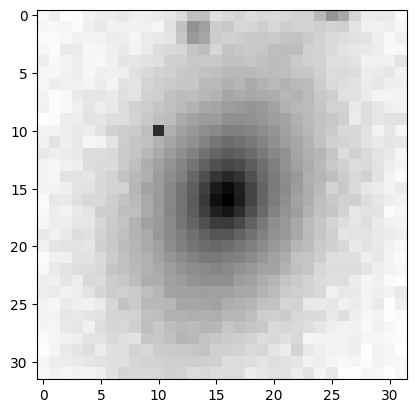

In [26]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {GalaxyClasses[pred_class]} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(32, 32), cmap='gray');

## Q: Consider the ensemble case! Try transforming the image (rotation, flip, slightly changing pixel values) and generating additional counterfactual examples. What does that tell us about what our model is sensitive to?
Some helpful functions are `torch.rot90` and `torch.flip`. 

Explanation took 165.436 sec.
Counterfactual prediction: Spiral with probability 0.9536458849906921


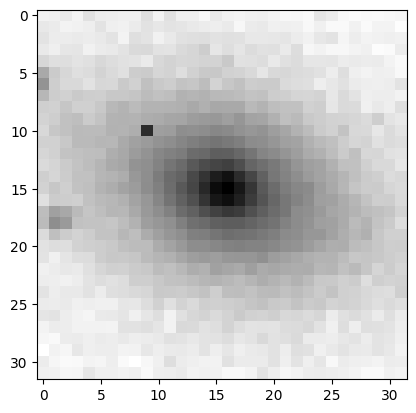

Explanation took 164.853 sec.
Counterfactual prediction: Irreg. with probability 0.9516168236732483


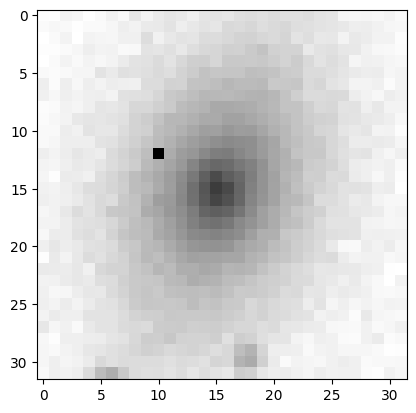

Explanation took 237.189 sec.
Counterfactual prediction: Irreg. with probability 0.9535085558891296


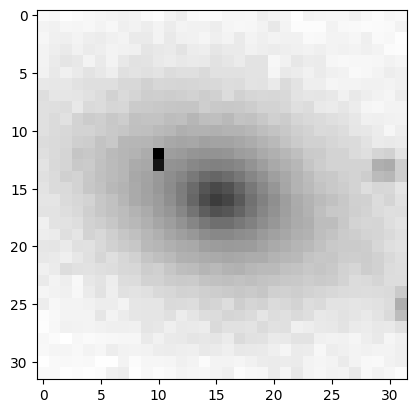

Explanation took 123.502 sec.
Counterfactual prediction: Ellip. with probability 0.9758943319320679


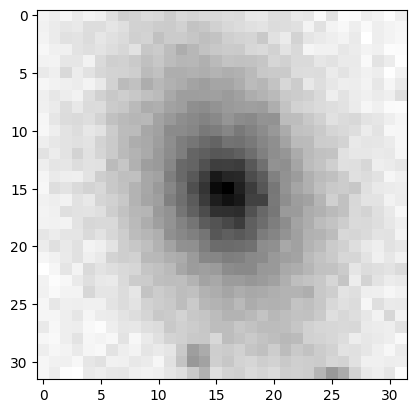

In [52]:
X_rot90 = torch.rot90(X, k=1, dims=[2, 3])
X_rot180 = torch.rot90(X, k=2, dims=[2, 3])
X_rot270 = torch.rot90(X, k=3, dims=[2, 3])
X_flip = torch.flip(X, [1, 2])

for X_transform in [X_rot90, X_rot180, X_rot270, X_flip]:
    start_time = time()
    explanation = cf.explain(X_transform);
    print('Explanation took {:.3f} sec.'.format(time() - start_time))
    pred_class = explanation.cf['class']
    proba = explanation.cf['proba'][0][pred_class]
    
    print(f'Counterfactual prediction: {GalaxyClasses[pred_class]} with probability {proba}')
    plt.imshow(explanation.cf['X'].reshape(32, 32), cmap='gray');
    plt.show()

The example seems trivial but the insight doesn't need to be. This may be telling us that irregular galaxies often have bright spots off-center in their respective images. The location of the pixel is a bit concerning, and may speak to the sensitivity of the model. We could continue to re-run for additional counterfactuals and confirm that's what the network considers archetypal for its class. At the bottom, the elliptical counterfactual has a much brighter core, expected for the class.

During the fitting technique, the regularization parameter $\lambda$ is slowly changed to 

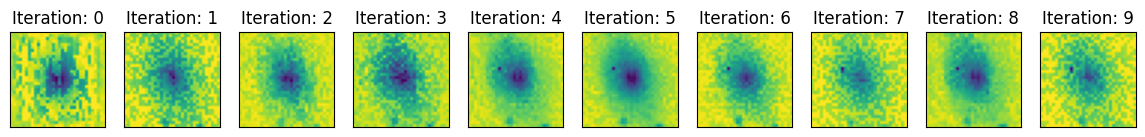

In [54]:
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(10)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(32,32))
    plt.title(f'Iteration: {key}')

Each of these are technically counterfactuals of the original image, but with slightly different regularization parameters determining how similar the new features of $x'$ are to the original features $x$. Now let's see what it takes to point the counterfactual toward a specific class - this time we'll aim for creating an elliptical classification.

In [55]:
target_class = 0 # elliptical galaxy

tf.keras.backend.clear_session()

cf = Counterfactual(predictor, shape, distance_fn='l1', target_proba=1.0,
                    target_class=target_class, max_iter=100, early_stop=50, lam_init=1e-1,
                    max_lam_steps=10, tol=0.05, learning_rate_init=0.1,
                    feature_range=(0, 1), eps=0.01, init='identity',
                    decay=True, write_dir=None, debug=False)

explanation = start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 26.106 sec


Our counterfactual is now the following:

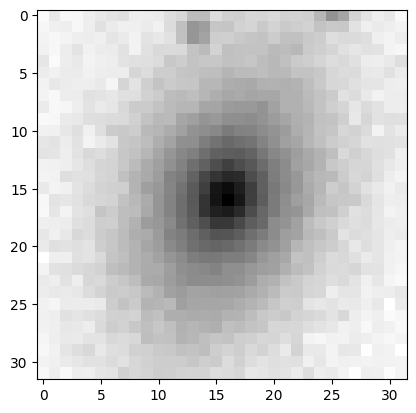

In [56]:
plt.imshow(explanation.cf['X'].reshape(32, 32), cmap='gray');

And to confirm that this would have indeed been classified as an elliptical:

In [57]:
pred_class = explanation.cf['class']

print(f'Counterfactual prediction: {GalaxyClasses[pred_class]} with probability {proba}')

Counterfactual prediction: Ellip. with probability 0.9758943319320679


It looks like a bright central region is archetypal of an elliptical - and maybe the structure is the algorithm trying to create a more elliptical nucleus? 

In [206]:
from alibi.explainers import CounterfactualProto

## 4.2.2. Time-series Counterfactuals

Next, we'll explore counterfactuals from the realm of supernova science. Supernovae are the explosive deaths of stars, and we detect these phenomena as transient events in data from (typically) optical telescopes. As our discovery rates have grown, we've resorted to characterizing these events by photometry alone - spectroscopic follow-up is too resource-intensive to study everything. The large associated data volumes and the subtle differences between photometric samples makes this a natural case study for machine learning classification tools.

Let's first look at some simulated supernova photometry. These data are obtained from the Photometric Supernova Classification Challenge (SPCC, Kessler et al. 2010), and presented in $griz$ passbands from the Dark Energy Survey (DES).

In [75]:
!pip install sncosmo iminuit

In [132]:
import sncosmo
from astropy.table import Table
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
transientPath = 'data/supernova/lightcurves/'

lc_file = os.path.join(transientPath, '34.dat')
lc = Table.read(lc_file, format='ascii')

In [469]:
print(lc)

        mjd          filter   flux  flux_error  zp  zpsys
-------------------- ------ ------- ---------- ---- -----
                 0.0   desg  -6.815      4.788 27.5    ab
 0.01600000000325963   desr   1.816      5.335 27.5    ab
0.031000000002677552   desi   4.239      5.437 27.5    ab
 0.06199999999807915   desz   7.875      4.693 27.5    ab
                 2.0   desg    1.68      2.238 27.5    ab
   2.139999999999418   desr   6.167      3.034 27.5    ab
  2.1560000000026776   desi   13.68      4.209 27.5    ab
   2.186999999998079   desz   4.787      3.519 27.5    ab
   9.984000000004016   desg  0.3359      1.702 27.5    ab
                10.0   desr   9.071      1.268 27.5    ab
   10.01600000000326   desi   10.84      1.912 27.5    ab
  10.039000000004307   desz   9.328      2.183 27.5    ab
  11.976000000002387   desg   3.278       9.76 27.5    ab
  11.988000000004831   desr   9.122      3.883 27.5    ab
  12.004000000000815   desi   5.254      8.073 27.5    ab
  12.031000000

A common pre-processing step is `feature extraction`: a model is fit to the supernova photometry and classification is done with these model features. Here, we'll fit a light curve to SALT2 (Guy et al., 2007), which was created for type Ia supernovae.

Best fitting SALT2 parameters: [z, t0, x0, x1, c]:
[ 7.28385580e-01  1.98758379e+01  2.50842809e-05  2.20457380e+00
 -2.65958520e-01]


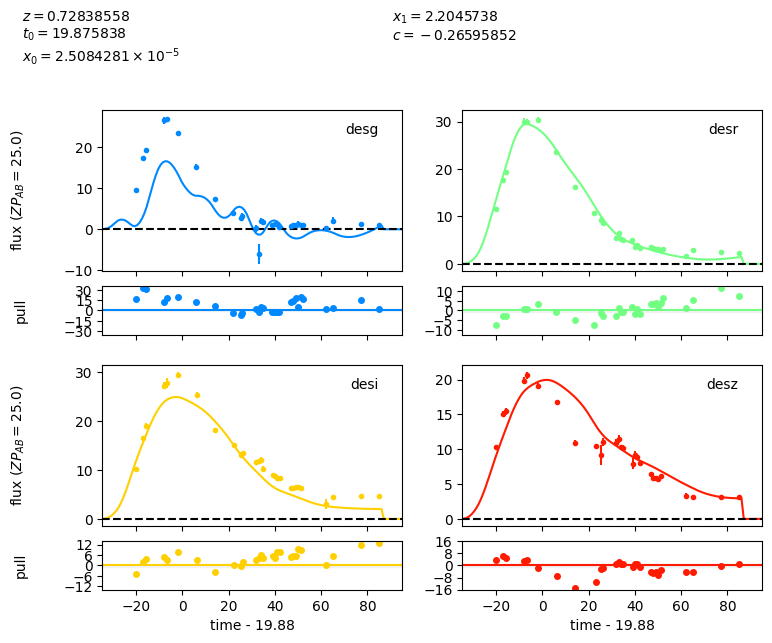

In [76]:
def fit_supernova(lc):
    """
    Small function to fit a light curve with the SALT2 model, using sncosmo and iminuit.
    
    Parameters
    -----------
    lc : astropy.table.Table
        Light curve (in the format sncosmo expects)
    
    Returns
    ----------
    z, t0, x0, x1, c
        Best-fitting parameters of the model
    """
    bnds = {'z':(0.01, 1.5), 't0':(-100,100),'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names, bounds=bnds, minsnr=0)
    return res[0].parameters

prms = fit_supernova(lc)
print('Best fitting SALT2 parameters: [z, t0, x0, x1, c]:')
print(prms)

mod = sncosmo.Model('salt2-extended')
mod.parameters = prms
sncosmo.plot_lc(lc, mod);

The SALT2 features for all supernovae in this sample have been pre-computed, and the classifications are given (1 = Ia, 2 = II, 3 = Ibc):

In [325]:
SNclasses = {1:'SN Ia', 2:'SN II', 3:'SN Ibc'}

In [400]:
salt2_features = np.loadtxt(os.path.join('data/supernova/','salt2_features.txt'), comments='#')
labels = np.loadtxt(os.path.join('data/supernova/','labels.txt'), comments='#')

from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X = SS.fit_transform(salt2_features[:, 1:])
y = labels[:, 1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#re-balance the training set: 
under = RandomUnderSampler(random_state=42, sampling_strategy={2: 500, 1: 404, 3: 190})
over = RandomOverSampler(random_state=42, sampling_strategy={2: 500, 1: 500, 3: 500})
steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps=steps)
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

In [276]:
#Create a Support Vector Machine Classifier
clf = svm.SVC(kernel='rbf', probability=True) 

#Train the model
clf.fit(X_train_res, y_train_res)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

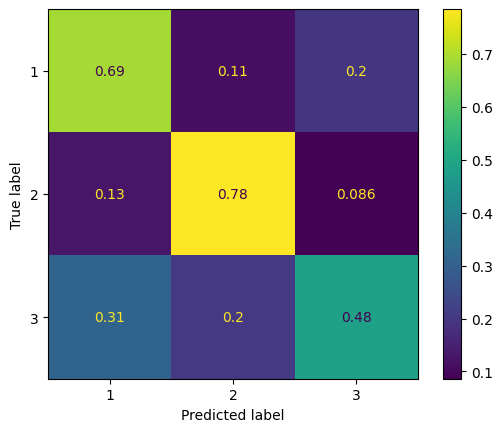

In [277]:
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

Not horrible. Now let's compute some counterfactuals for a single example. First looking at the event for which we'd like a counterfactual:

Event is an SN Ia.


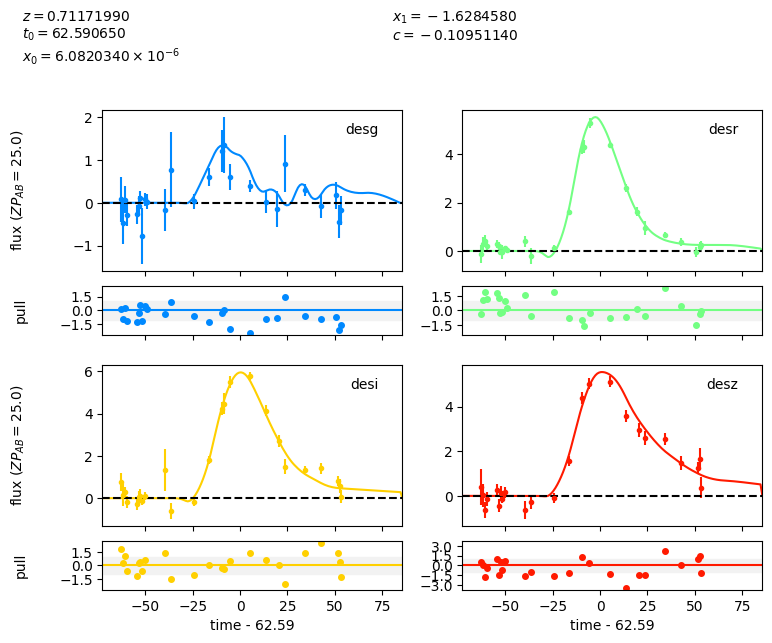

In [545]:
lc_file = os.path.join(transientPath, '5.dat')
lc = Table.read(lc_file, format='ascii')

mod_orig = sncosmo.Model('salt2-extended')
mod_orig.parameters = salt2_features[5][1:]
sncosmo.plot_lc(lc, mod_orig);

print("Event is an %s." % SNclasses[labels[5, 1]])

In [546]:
predictor = lambda x: clf.predict_proba(x)

tf.keras.backend.clear_session()

cf = Counterfactual(predictor, shape, distance_fn='l1', target_proba=1.0,
                    target_class=1, max_iter=1000, lam_init=1e-5,
                    max_lam_steps=50, tol=0.05, learning_rate_init=0.1,
                    feature_range=(-1.e5, 1.e5), eps=0.01, init='identity',
                    decay=True, write_dir=None, debug=False)

explanation = start_time = time()
explanation = cf.explain(X[5].reshape(1, -1))
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 13.390 sec


And now, let's investigate the counterfactual:

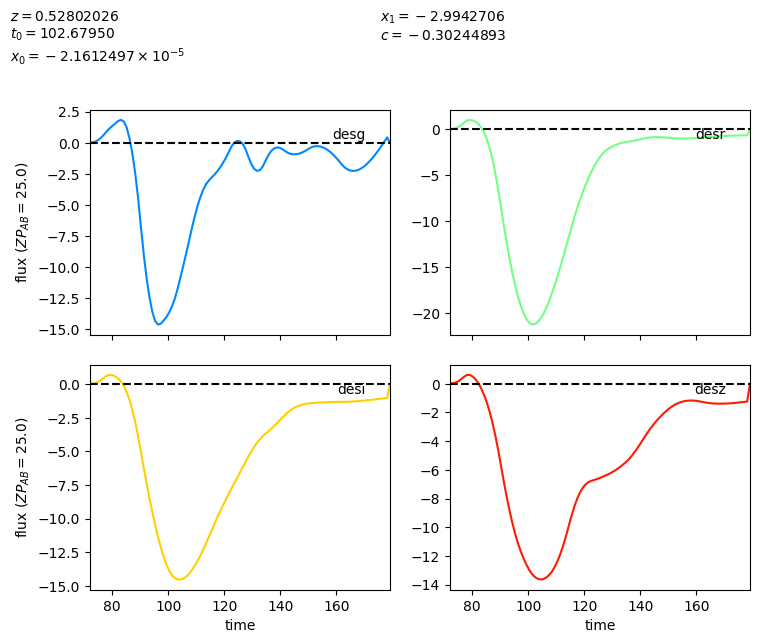

In [547]:
mod_counter = sncosmo.Model('salt2-extended')
mod_counter.parameters = SS.inverse_transform(explanation.cf['X'][0].reshape(1, -1))[0]
sncosmo.plot_lc(data=None, bands=['desg','desr', 'desi', 'desz'], model=mod_counter);

The scale seems roughly right, but most obvious is that the supernova _dims_ instead of _brightening_. To get counterfactuals more closely matching the training dataset, we can use _prototypes_. This trick comes from a paper in 2019, [Interpretable Counterfactual Explanations Guided by Prototypes](https://arxiv.org/abs/1907.02584). By adding a term $L_{\rm{proto}}$ to the loss function, we can guide our counterfactuals toward examples that fall within the data distribution _and_ differ from our sample class $i$. The additional term is defined as 
$$
L_{\rm{proto}} = \theta \;  || ENC(x+\delta) - \rm{proto}_j||_2^2
$$
where $i \neq j$. This term penalizes counterfactuals far from a given prototype. To make this work, however, we need a way of _encoding_ our counterfactual $x+\delta$ and a set of class prototypes. How do we create these?

* Autoencoders
* kd-trees

We'll explore the second example below.

In [593]:
tf.keras.backend.clear_session()

cf = CounterfactualProto(predictor, shape, use_kdtree=True, theta=100., feature_range=(-1.e3, 1.e3))
cf.fit(X_train, trustscore_kwargs=None)
explanation = cf.explain(X[5].reshape(1, -1),  k=2)

No encoder specified. Using k-d trees to represent class prototypes.


and now, let's investigate the counterfactual. What class is it predicted to be?

In [594]:
pred_class = explanation.cf['class']
print(f'Counterfactual prediction: {SNclasses[pred_class]}')

Counterfactual prediction: SN II


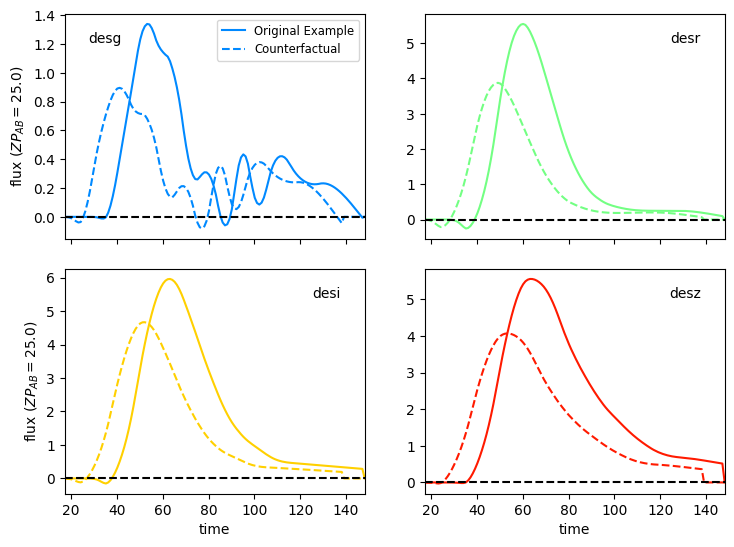

In [595]:
#and now, the counterfactual
mod_counter.parameters = SS.inverse_transform(explanation.cf['X'][0].reshape(1, -1))[0]
sncosmo.plot_lc(data=None, bands=['desg','desr', 'desi', 'desz'], model=[mod_orig, mod_counter], model_label=['Original Example', 'Counterfactual']);

Note that because we're using kdtrees, our prototypes are actual examples from our training set. In the autoencoder case, the prototypes are defined as the average of the k-nearest encodings of a given class $i \neq j$.

In [596]:
#let's see how the input parameters differ; this is what needs to be changed to take us from an SN Ia to an SN II
counter_params =  SS.inverse_transform(explanation.cf['X'][0].reshape(1, -1))[0]
initial_params =  SS.inverse_transform(X[5].reshape(1, -1))[0]
parm_diffs = counter_params - initial_params

In [597]:
print("SALT2 parameters: [z, t0, x0, x1, c]")
print("Absolute parameter changes")
print(parm_diffs)
print("Fractional parameter changes")
print(parm_diffs/initial_params)

SALT2 parameters: [z, t0, x0, x1, c]
Absolute parameter changes
[ 2.65137259e-02 -1.06743368e+01 -1.62683510e-06 -8.37876720e-03
  2.22101211e-09]
Fractional parameter changes
[ 3.72530344e-02 -1.70542035e-01 -2.67482078e-01  5.14521541e-03
 -2.02811042e-08]


These parameters are redshift (z), starting time (t0), amplitude (x0), light curve stretch (x1), and color (c). 

The counterfactual, then, has about the same redshift, but looks dimmer than the example event and starts earlier. Our counterfactual both looks like a supernova now, and has some desirable physical properties: type Ia supernovae) are significantly brighter than SNe II on average, and we see this in our case. 